# Statistical tests
In this notebook we will cover some common statistical tests, the type of experiments they can be used to test and the assumptions that are built into the tests.

These tests normally return a p-value, this is the probability of observing a result as or more extreme as the one you actually observed if the null hypothesis is true. For example, when comparing two groups, the null hypothesis is that the mean of the two groups, if you could take infinite samples, would be the same. If the groups we observed are very different it is unlikely that their means are the same, likewise if they are only slightly different by we have taken many samples it is unlikely that the means are the same.

If the results you found would be extremely unlikely if the null hypothesis were true (meaning that your p value is very small), then you can reject the null hypothesis, and say that the change which you observed is because of a real change that you made to the system. This is called a statistically significant result.

People normally declare their results to be statistically significant if the p-value is less than 0.05. However, this also means that your false positive rate, if the change you made to the system had no real effect, is 5%. 

This false positive rate is quite high, and many people think that we should lower the threshold to 0.01 or even lower for new or surprising results. The threshold you choose is up to you, choosing a less conservative thresold (a larger p-value) increases the risk of a false positive but decreases the size of the experiment which you need to do, the notebook on power analysis contains more information on this topic.

It is also possible to combine multiple p-values which relate to the same hypothesis. For example if you have run tests at several scales, testing a particular product or change in a variety of situations. At the end of this process you will have multiple p-values relating to the same hypothesis, these can be combined into an overall p-value for the hypothesis. 

Lastly, the p-value shouldn't be confused with the likelyhood that the null hypothesis is true.  To illustrate this point, imagine a field of science where they only tested obviously false hypotheses, eg: shouting at the moon makes it larger etc.. In this field, if using a threshold p-value of 0.05 they would still get positive results 5% of the time, but all of their results would be false positives. 

# The t-test - two groups

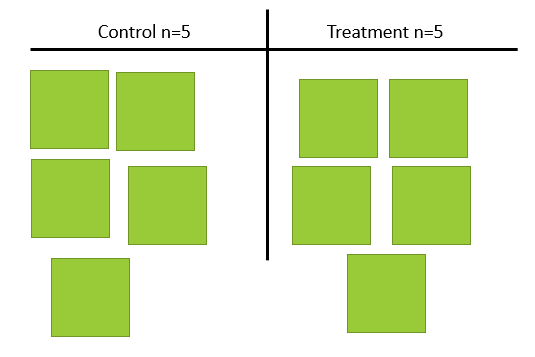

The t-test is a very common test, this is used to test the difference between two means. You would use this test if you had two groups in your data (eg one with a coating and one without, or one set of tests with degraded oil and one with new oil, or one set of tests at a low force and one at a high force).

The t-test assumes:
- The sample means are normally distributed
- The values in each sample are independent
- The values in each sample are identically distributed

Practically the first assumption is often true, especially if we have a large number of repeats (eg 30) or if our samples are close to being normally distributed. The reason for this is explained in the notebook on the central limit theorem.

The values in each group being independent maens that the values should not depend on eachother in any way. For example consecutive time series measurments depend strongly on each other, thus a t-test using these would be invalid.

The values in each group being identically distributed means that they must be the same type of measurment from the same experiment, you cannot compare a mixture of temperature and force results for example.

In the standard t-test we also assume that the variation in each group is the same. However if we don't think this will be true we can use a slightly different form of the test easily.

In this example we will generate some example test data, plot it and use a t-test to compare the groups.


In [1]:
import numpy as np
np.random.seed(0)
from scipy.stats import ttest_ind
n = 10
difference = 1
control = np.random.randn(n)
treatment = difference + np.random.rand(n)
result = ttest_ind(control, treatment)
print(f"Our p value is: {result.pvalue}, this is smaller than 0.05, so we say"
      " it is statistically significant")

Our p value is: 0.029274163837151337, this is smaller than 0.05, so we say it is statistically significant


Now lets do the same thing but without assuming that the variaion in the samples is the same:

In [2]:
result = ttest_ind(control, treatment, equal_var=False)
print(f"Our p value is: {result.pvalue}, this is larger than 0.05, so we say"
      " it is NOT statistically significant")

Our p value is: 0.03690086303417882, this is larger than 0.05, so we say it is NOT statistically significant


We can see that if we don't assume equal variance then the test is more conservative. This is generally true, the less we assume about our data the harder it is to be certain about what we observe.

---

# Paired t-test



Often our data is paired in some way, for example, if we have before and after tests on the same samples. In these cases you are not really interested in the variation of the whole group, you just want to know what effect your change had. 

For this sort of experiment we can use a paired t-test. This has the same assumptions as the normal t-test described above, however we do not assume equal varience in the groups as we are only testing the difference between the groups.

In the example below we will generate some paired data then test it with a t-test.

In [3]:
np.random.seed(0)
from scipy.stats import ttest_rel # <ttest_rel for paired, ttest_ind for independent
n = 10
difference = 0.1
control = np.random.randn(n)
# here the treatment value also depends on the control value, so they are paired
treatment = control + difference + np.random.rand(n)
result = ttest_rel(control, treatment)
print(f"Our p value is: {result.pvalue}, this is smaller than 0.05, so we say"
      " it is statistically significant")

Our p value is: 0.0002925302691464218, this is smaller than 0.05, so we say it is statistically significant


# The 1 way ANOVA

If we extend the example above to three or more groups in the data, eg. one control and two treatments. We can use a ANOVA (also called f-test) to compare the groups. This will automatically account for the fact that we are doing multiple comparisons on our data. 

This test assumes that:
- The varience in each group is the same
- The samples in each group are normally distributed
- The values in each sample are independent

In prcatice the ANVOA has been tested extensively and found to be robust to deviations from normality and different variences in each group, if the number of samples in each groups is the same and the values in each group are identically distributed (one distribution per group). 

One limitation of the ANOVA is that it only provides a single p-value for the whole experiment. In practice we are often interested in what the difference between the groups are, not just the fact that there are some differences. In order to find this we must use post tests to check the differences we are interested in.

In the example below we will generate 3 groups of data, representing a control and two different treatment groups. We will test the overall result with an ANOVA, then use post tests to investigate which of the two treatment goups is different to the control group.

In [4]:
np.random.seed(0)
from scipy.stats import f_oneway
n = 15
control_group = np.random.randn(n)
treatment_1 = np.random.randn(n)
treatment_2 = 2 + np.random.randn(n)
result = f_oneway(control, treatment_1, treatment_2)
print(f"The p-value from the anova is {result.pvalue:.3f}, therfore"
      " there are significant differences between the groups")

The p-value from the anova is 0.003, therfore there are significant differences between the groups


In [5]:
# now we will use t-tests as post tests, but we will correct for multiple comparisons 
from statsmodels.stats.multitest import multipletests
unadjusted_p=[ttest_ind(control_group, treatment_1).pvalue, 
              ttest_ind(control_group, treatment_2).pvalue]
real_p_values = multipletests(unadjusted_p)
print(f'control vs treatment 1 p-values = {real_p_values[1][0]}\n')
print(f'control vs treatment 2 p-values = {real_p_values[1][1]}\n')
print('Only treatment 2 is significantly different from the control group')

control vs treatment 1 p-values = 0.23047361277666756

control vs treatment 2 p-values = 0.012786010376910184

Only treatment 2 is significantly different from the control group


Alternatively we can test all possible pairwise comparisons, however note that the more comparisons we do the more we have to adjust our results to avoid false positives.

In [6]:
# now we will use t-tests as post tests, but we will correct for multiple comparisons 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
data = np.concatenate([control_group, treatment_1, treatment_2])
groups = np.array([['control']*n, ['treatment_1']*n, ['treatment_2']*n]).flatten()
print(pairwise_tukeyhsd(data, groups))

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
    control treatment_1  -0.4883 0.4525 -1.4641 0.4875  False
    control treatment_2   1.0785 0.0273  0.1027 2.0542   True
treatment_1 treatment_2   1.5668  0.001   0.591 2.5425   True
-------------------------------------------------------------


# Regression
There is a mode detailed note book on regession, pleas check that note book for datails